In [ ]:
! pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    AutoTokenizer, 
    AutoModel,
    get_linear_schedule_with_warmup,
    BertModel,
    BertTokenizer,
    BertTokenizerFast
)

In [ ]:
import json
import pandas as pd
import numpy as np
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
df = pd.read_csv('dataset.csv')
print(df.shape)  
df.head()

(1097, 4)


,_id,tweet_text,tweet_lang,tweet_sentiment_value
0,595e60b48fcd022a715f7b7b,this airfrance b777-300er has the oldest ifes i\ve ever seen. it belongs in a museum. the terrible smell isn\t helping either.,en,0
1,595e60de8fcd022a715f7b7d,???? will miss my connection airfrance https://t.co/2olmtwcxyk,en,0
2,595e61448fcd022a715f7b7f,"airfrance lost luggage in overhead cabin, email no response, phone no one answers. pls help.",en,0
3,595e62748fcd022a715f7b83,"here\s a new twist on the \""all airlines hate musicians\"" saga. we saw our gear the plane amp; yet now airfrance have no clue where it is!!!",en,0
4,595e62b28fcd022a715f7b86,airfrance so now i might not have 3 pieces of my most important gear 4 the most important dublin show i\ve ever done. thanks airfrance,en,0


In [ ]:
#df['tweet_sentiment_value'].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   _id                    1097 non-null   object
 1   tweet_text             1097 non-null   object
 2   tweet_lang             1097 non-null   object
 3   tweet_sentiment_value  1097 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 34.4+ KB


No null values found in dataset.

In [ ]:
df.columns

Index(['_id', 'tweet_text', 'tweet_lang', 'tweet_sentiment_value'], dtype='object')

In [ ]:
val_count = df['tweet_sentiment_value'].value_counts()
print(val_count)

1    502
0    406
2    189
Name: tweet_sentiment_value, dtype: int64


Text(0.5, 1.0, 'Data Distribution')

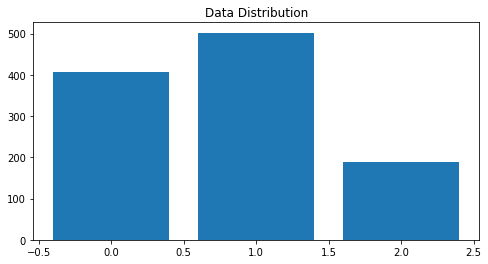

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Data Distribution")

# **Data Cleaning**

In [ ]:
# Remove HTML tags
df['tweet_text'] = df['tweet_text'].str.replace('<[^<]+?>', '')

# Remove punctuation and special characters
df['tweet_text'] = df['tweet_text'].str.replace('[^\w\s]','')

<ipython-input-83-7270ab2ca4bc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet_text'] = df['tweet_text'].str.replace('<[^<]+?>', '')
<ipython-input-83-7270ab2ca4bc>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet_text'] = df['tweet_text'].str.replace('[^\w\s]','')


In [ ]:
df.head()

,_id,tweet_text,tweet_lang,tweet_sentiment_value
0,595e60b48fcd022a715f7b7b,this airfrance b777300er has the oldest ifes ive ever seen it belongs in a museum the terrible smell isnt helping either,en,0
1,595e60de8fcd022a715f7b7d,will miss my connection airfrance httpstco2olmtwcxyk,en,0
2,595e61448fcd022a715f7b7f,airfrance lost luggage in overhead cabin email no response phone no one answers pls help,en,0
3,595e62748fcd022a715f7b83,heres a new twist on the all airlines hate musicians saga we saw our gear the plane amp yet now airfrance have no clue where it is,en,0
4,595e62b28fcd022a715f7b86,airfrance so now i might not have 3 pieces of my most important gear 4 the most important dublin show ive ever done thanks airfrance,en,0


# **Preparing training and testing data**

In [ ]:
#Shuffling the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
#split the subset by sentiment value to create new train, val and test splits
import collections
by_rating = collections.defaultdict(list)
for _,row in df.iterrows():
  by_rating[row.tweet_sentiment_value].append(row.to_dict())

In [ ]:
#create split data
seed =1021
final_list = []
np.random.seed(seed)
train_proportion = 0.7
val_proportion = 0.2
test_proportion = 0.1

for _, item_list in sorted(by_rating.items()):
  np.random.shuffle(item_list)

  n_total = len(item_list)
  n_train = int(train_proportion * n_total)
  n_val = int(val_proportion * n_total)
  n_test = int(test_proportion * n_total)

  #give data points  split attribute
  for item in item_list[:n_train]:
    item['split'] = 'train'

  for item in item_list[n_train:n_train+n_val]:
    item['split'] = 'val'

  for item in item_list[n_train+n_val:n_train+n_val+n_test]:
   item['split'] = 'test'

  final_list.extend(item_list)

df_new = pd.DataFrame(final_list)
     


In [ ]:
df_new.head()

,_id,tweet_text,tweet_lang,tweet_sentiment_value,split
0,5962678f4fe31f4f52a01f4d,delta whats going on lax nothing but prbsbad communication among staffresultlost luggage with no trace on rerouted flight airfrance,en,0,train
1,59604fc2745dc32c7a70a973,jfkairport airfrance update 124 mins still no gate over 25 of our flight time sitting on the ground after httpstcoocyhkcpexh,en,0,train
2,595e67078fcd022a715f7bb1,thecollinsshow airfrance i dont believe they deal in the business of making sure their customers are properly se httpstcolcmpqwpxbg,en,0,train
3,595f7e6c745dc32c7a70a797,airfrance this is awful 212 hours in the security line and at least 40 mins to go flight 32 to ny will have no httpstcogl9ol6elmn,en,0,train
4,59646a3f4fe31f4f52a023fc,airfrance worst lost baggage service ever rude agents total disregard for customers dontflythem,en,0,train


<AxesSubplot:xlabel='tweet_sentiment_value'>

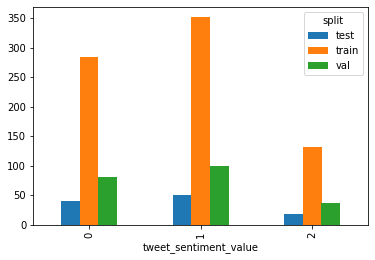

In [ ]:
df_new.groupby(['tweet_sentiment_value','split']).size().unstack(level=1)  
a=df_new.groupby(['tweet_sentiment_value','split']).size().unstack(level=1)  
a.plot(kind='bar')

In [ ]:
df_new.groupby(['tweet_sentiment_value','split']).size()

tweet_sentiment_value  split
0                      test      40
                       train    284
                       val       81
1                      test      50
                       train    351
                       val      100
2                      test      18
                       train    132
                       val       37
dtype: int64

In [ ]:
df_train = df_new[df_new.split=='train']
df_val = df_new[df_new.split=='val']
df_test= df_new[df_new.split=='test']

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(767, 5)
(218, 5)
(108, 5)


Shuffling datasets

In [ ]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [ ]:
#Getting texts and labels
sentences_train = df_train.tweet_text.values
labels_train = df_train.tweet_sentiment_value.values

sentences_valid = df_val.tweet_text.values
labels_valid = df_val.tweet_sentiment_value.values

sentences_test = df_test.tweet_text.values
labels_test = df_test.tweet_sentiment_value.values

In [ ]:
#Tokenization using BERT Tokeniser
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def create_input_ids_attention_maks(sentences, max_len):
  input_ids = []

  # For every sentence...
  for sent in sentences:
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          sent,                      
                          add_special_tokens = True,
                          max_length = max_len,         
                          truncation=True
                          
                    )
      
      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent)

  
  # pad the sequences
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                            value=0, truncating="post", padding="post")
  

  # Create attention masks
  attention_masks = []

  for sent in input_ids:
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]
      
      attention_masks.append(att_mask)

  return [input_ids, attention_masks]
     

In [ ]:
input_ids_train, attention_masks_train = create_input_ids_attention_maks(sentences_train, 30)
input_ids_valid, attention_masks_valid = create_input_ids_attention_maks(sentences_valid, 30)
input_ids_test, attention_masks_test = create_input_ids_attention_maks(sentences_test, 30)

In [ ]:
print(' Original: ', sentences_train[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_train[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

 Original:  on 26th april 120 monkeys were shipped by air france over 10000 miles from mauritius to the us httpstcom8ipldpivt
Tokenized:  ['on', '26th', 'april', '120', 'monkeys', 'were', 'shipped', 'by', 'air', 'france', 'over', '1000', '##0', 'miles', 'from', 'mauritius', 'to', 'the', 'us', 'https', '##tc', '##om', '##8', '##ip', '##ld', '##pi', '##v', '##t']
Token IDs:  [2006, 14935, 2258, 6036, 17059, 2020, 12057, 2011, 2250, 2605, 2058, 6694, 2692, 2661, 2013, 18004, 2000, 1996, 2149, 16770, 13535, 5358, 2620, 11514, 6392, 8197, 2615, 2102]


In [ ]:
input_ids_train.shape

(767, 30)

**Creating Torch Tensors for Data Loader**

In [ ]:
train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_valid)
test_inputs = torch.tensor(input_ids_test)


train_labels = torch.tensor(labels_train)
validation_labels = torch.tensor(labels_valid)
test_labels = torch.tensor(labels_test)

train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_valid)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

batch_size = 16


# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
#     model = model.cuda()
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Setting Up Optimiser and Scheduler**

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_dataloader)*epochs)

**Setting Performance Metrics**

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
label_dict = {'Positive':2, 'Negative':0, 'Neutral':1}

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# **Training the model**

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):   
    model.train()   
    loss_train_total = 0
    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)    
    
    for batch in progress_bar:
        model.zero_grad()  #backward pass     
        #add batch to GPU
        batch = tuple(b.to(device) for b in batch)          
        #Unpack the inputs from dataloader
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       
        outputs = model(**inputs) #forward pass
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()   #backward pass to calculate gradients

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})    
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    #evaluating model
    val_loss, predictions, true_vals = evaluate(validation_dataloader)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9587126473585764
Validation loss: 0.8090617145810809
F1 Score (Weighted): 0.6048415750886146


Epoch 2:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6480680691699187
Validation loss: 0.5474942965166909
F1 Score (Weighted): 0.7846236063377291


Epoch 3:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3975261515006423
Validation loss: 0.5248043845806803
F1 Score (Weighted): 0.7829725179632134


Epoch 4:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.25785984098911285
Validation loss: 0.5041532106697559
F1 Score (Weighted): 0.8162965122232217


Epoch 5:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.17108432645909488
Validation loss: 0.5410563413585935
F1 Score (Weighted): 0.7745565459426663


In [ ]:
#last batch
accuracy_per_class(predictions, true_vals)

Class: Negative
Accuracy: 69/81

Class: Neutral
Accuracy: 71/100

Class: Positive
Accuracy: 29/37



**Model Evaluation using Validation Data**

In [ ]:
_, predictions, true_vals = evaluate(validation_dataloader)

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: Negative
Accuracy: 69/81

Class: Neutral
Accuracy: 71/100

Class: Positive
Accuracy: 29/37



In [ ]:
predictions

array([[ 2.9528463 , -0.4547087 , -2.038586  ],
       [ 3.058204  , -0.77800834, -1.7722652 ],
       [-1.3414283 ,  2.5613194 , -0.97365505],
       [ 2.5976143 , -0.6157534 , -1.700049  ],
       [-2.2838368 ,  0.1301396 ,  1.8738713 ],
       [-0.6492725 ,  2.4910834 , -1.4323667 ],
       [ 2.9806743 , -0.7404622 , -1.7593293 ],
       [ 2.6116455 , -0.79769814, -1.5627047 ],
       [ 0.08179312,  2.1197202 , -1.8083915 ],
       [ 2.7890637 , -0.6557568 , -1.7711924 ],
       [ 0.3329713 ,  0.7763348 , -1.4617028 ],
       [ 1.047281  ,  1.9031906 , -2.3276868 ],
       [ 2.6283836 , -0.10386928, -2.2129917 ],
       [ 2.9655952 , -0.6408437 , -1.9468724 ],
       [-2.0590556 , -0.8465061 ,  2.292283  ],
       [ 2.9964068 , -0.5792307 , -2.0027826 ],
       [-1.0565969 ,  3.0046601 , -1.3016962 ],
       [-1.0441172 ,  1.2246709 ,  0.20693843],
       [ 2.770916  ,  0.29329938, -2.4046855 ],
       [ 1.8078893 ,  1.175369  , -2.3529463 ],
       [ 0.8761028 ,  2.1355913 , -2.119

In [ ]:
true_vals

array([0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 0, 2, 0, 1, 2, 0, 1, 1, 1,
       1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 2,
       1, 2, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 1, 2, 2, 2, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 0, 1,
       0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 2,
       0, 1, 0, 1, 1, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 2, 1, 0, 0, 1,
       2, 0, 1, 0, 1, 0, 2, 0, 1, 2, 2, 2, 1, 2, 0, 1, 1, 0, 2, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0])

In [ ]:
input_ids_list = []

for batch in validation_dataloader:
    # Get input_ids tensor from the batch
    input_ids = batch[0]
    input_ids_list.append(input_ids)

In [ ]:
sent=[]
for i in (input_ids_list):
  for j in i:
    x=tokenizer.convert_ids_to_tokens(j)
    #print(x)
    sent.append(x)

In [ ]:
len(sent)

218

In [ ]:
true_vals.shape

(218,)

In [ ]:
predictions.shape

(218, 3)

In [ ]:
y_true=true_vals.flatten()

In [ ]:
y_pred=predictions.flatten()

In [ ]:
preds_flat = np.argmax(predictions, axis=1).flatten()
#labels_flat = labels.flatten()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_vals, preds_flat))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81        81
           1       0.82      0.71      0.76       100
           2       0.69      0.78      0.73        37

    accuracy                           0.78       218
   macro avg       0.76      0.78      0.77       218
weighted avg       0.78      0.78      0.77       218



In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_vals, preds_flat)

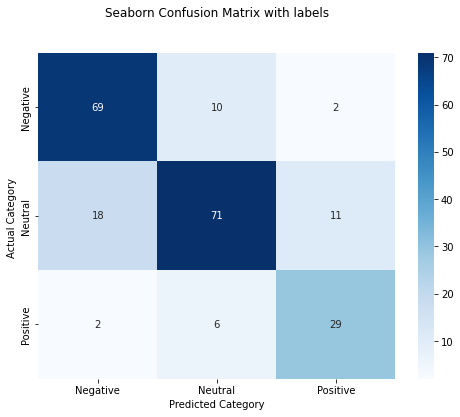

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('Predicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Negative","Neutral","Positive"])
ax.yaxis.set_ticklabels(["Negative","Neutral","Positive"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
df=pd.DataFrame()
df['Actual Label']= y_true
df['Tokenised Text']=sent
df['predictions']= preds_flat

In [ ]:
#'Positive':2, 'Negative':0, 'Neutral':1
df.head()

,Actual Label,Tokenised Text,predictions
0,0,"[[CLS], air, ##fra, ##nce, all, i, need, is, my, seat, assigned, and, no, one, will, help, me, just, divert, ##ing, us, to, different, places, lack, of, cu, https, ##tc, [SEP]]",0
1,0,"[[CLS], just, when, you, think, air, france, can, ##t, get, any, more, un, ##pro, ##fe, ##ssion, ##al, they, go, and, contra, ##dict, themselves, worst, airline, https, ##tc, ##oot, ##gc, [SEP]]",0
2,1,"[[CLS], fly, ##be, im, trying, to, check, in, for, a, fly, ##be, flight, from, cd, ##g, tomorrow, red, ##ire, ##cted, to, an, air, france, website, which, can, ##t, find, [SEP]]",1
3,0,"[[CLS], air, ##fra, ##nce, james, ##v, ##mc, ##mo, ##rrow, you, guys, are, such, a, s, ##nob, ##by, rude, un, ##sy, ##mp, ##ath, ##etic, airline, don, ##t, even, try, this, [SEP]]",0
4,2,"[[CLS], nat, ##i, ##2, ##de, air, ##fra, ##nce, ic, ##k, loved, your, pic, ##s, though, [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD]]",2
